In [ ]:
pip install faiss-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 11.6 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
import os
import faiss
import copy
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from PIL import Image
from torchvision import transforms
import cv2
import time

class ArcMarginProduct(nn.Module):
    r"""Implement of large margin arc distance: :
        Args:
            in_features: size of each input sample
            out_features: size of each output sample
            s: norm of input feature
            m: margin
            cos(theta + m)
        """
    def __init__(self, in_features, out_features, s=30.0,
                 m=0.50, easy_margin=False, ls_eps=0.0, device=torch.device('cuda')):
        super(ArcMarginProduct, self).__init__()
        self.device = device
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.ls_eps = ls_eps  # label smoothing
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, input, label):
        # --------------------------- cos(theta) & phi(theta) ---------------------
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        # --------------------------- convert label to one-hot ---------------------
        # one_hot = torch.zeros(cosine.size(), requires_grad=True, device='cuda')
        one_hot = torch.zeros(cosine.size(), device=self.device)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.out_features
        # -------------torch.where(out_i = {x_i if condition_i else y_i) ------------
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s

        return output

class DenseCrossEntropy(nn.Module):
    def forward(self, x, target):
        x = x.float()
        target = target.float()
        logprobs = torch.nn.functional.log_softmax(x, dim=-1)

        loss = -logprobs * target
        loss = loss.sum(-1)
        return loss.mean()

class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super(FocalLoss, self).__init__()
        self.gamma = gamma

    def forward(self, x, target):
        x = x.float()
        target = target.float()
        probs = torch.nn.functional.softmax(x, dim=-1)
        logprobs = torch.log(probs)

        loss = -logprobs * target * (1 - probs) ** self.gamma
        loss = loss.sum(-1)
        return loss.mean()

class ArcMarginProduct_subcenter(nn.Module):
    def __init__(self, in_features, out_features, k=3):
        super().__init__()
        self.weight = nn.Parameter(torch.FloatTensor(out_features*k, in_features))
        self.reset_parameters()
        self.k = k
        self.out_features = out_features

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)

    def forward(self, features):
        cosine_all = F.linear(F.normalize(features), F.normalize(self.weight))
        cosine_all = cosine_all.view(-1, self.out_features, self.k)
        cosine, _ = torch.max(cosine_all, dim=2)
        return cosine

class ArcFaceLossAdaptiveMargin(nn.modules.Module):
    def __init__(self, margins, s=30.0, crit='ce'):
        super().__init__()
        if crit == 'ce':
            self.crit = DenseCrossEntropy()
        else:
            self.crit = FocalLoss()
        self.s = s
        self.margins = margins

    def forward(self, logits, labels, out_dim):
        ms = []
        ms = self.margins[labels.cpu().numpy()]
        cos_m = torch.from_numpy(np.cos(ms)).float().cuda()
        sin_m = torch.from_numpy(np.sin(ms)).float().cuda()
        th = torch.from_numpy(np.cos(math.pi - ms)).float().cuda()
        mm = torch.from_numpy(np.sin(math.pi - ms) * ms).float().cuda()
        labels = F.one_hot(labels, out_dim).float()
        logits = logits.float()
        cosine = logits
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        phi = cosine * cos_m.view(-1,1) - sine * sin_m.view(-1,1)
        phi = torch.where(cosine > th.view(-1,1), phi, cosine - mm.view(-1,1))
        output = (labels * phi) + ((1.0 - labels) * cosine)
        output *= self.s
        loss = self.crit(output, labels)
        return loss

def set_seed(seed):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)


def get_similiarity_hnsw(embeddings_gallery, emmbeddings_query, k):
    # this is guy is really fast
    print('Processing indices...')

    s = time.time()
    index = faiss.IndexHNSWFlat(embeddings_gallery.shape[1], 32)
    index.add(embeddings_gallery)

    scores, indices = index.search(emmbeddings_query, k)
    e = time.time()

    print(f'Finished processing indices, took {e - s}s')
    return scores, indices

def get_similiarity_l2(embeddings_gallery, emmbeddings_query, k):
    print('Processing indices...')

    s = time.time()
    index = faiss.IndexFlatL2(embeddings_gallery.shape[1])
    index.add(embeddings_gallery)

    scores, indices = index.search(emmbeddings_query, k)
    e = time.time()

    print(f'Finished processing indices, took {e - s}s')
    return scores, indices


def get_similiarity_IP(embeddings_gallery, emmbeddings_query, k):
    print('Processing indices...')

    s = time.time()
    index = faiss.IndexFlatIP(embeddings_gallery.shape[1])
    index.add(embeddings_gallery)

    scores, indices = index.search(emmbeddings_query, k)
    e = time.time()

    print(f'Finished processing indices, took {e - s}s')
    return scores, indices

def get_similiarity(embeddings, k):
    print('Processing indices...')

    index = faiss.IndexFlatL2(embeddings.shape[1])

    res = faiss.StandardGpuResources()

    index = faiss.index_cpu_to_gpu(res, 0, index)

    index.add(embeddings)

    scores, indices = index.search(embeddings, k)
    print('Finished processing indices')

    return scores, indices

def map_per_image(label, predictions, k=5):
    try:
        return 1 / (predictions[:k].index(label) + 1)
    except ValueError:
        return 0.0

def map_per_set(labels, predictions, k=5):
    return np.mean([map_per_image(l, p, k) for l,p in zip(labels, predictions)])

class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, window_size=None):
        self.length = 0
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        self.window_size = window_size

    def reset(self):
        self.length = 0
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        if self.window_size and (self.count >= self.window_size):
            self.reset()
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def get_lr_groups(param_groups):
        groups = sorted(set([param_g['lr'] for param_g in param_groups]))
        groups = ["{:2e}".format(group) for group in groups]
        return groups

def convert_indices_to_labels(indices, labels):
    indices_copy = copy.deepcopy(indices)
    for row in indices_copy:
        for j in range(len(row)):
            row[j] = labels[row[j]]
    return indices_copy

class Multisample_Dropout(nn.Module):
    def __init__(self, dropout_rate=0.1):
        super(Multisample_Dropout, self).__init__()
        self.dropout = nn.Dropout(dropout_rate)
        self.dropouts = nn.ModuleList([nn.Dropout((i+1)*.1) for i in range(5)])

    def forward(self, x, module):
        x = self.dropout(x)
        return torch.mean(torch.stack([module(dropout(x)) for dropout in self.dropouts],dim=0),dim=0)

def transforms_auto_augment(image_path, image_size):
    image = Image.open(image_path).convert('RGB')
    train_transforms = transforms.Compose([transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET), transforms.PILToTensor()])
    return train_transforms(image)

def transforms_cutout(image_path, image_size):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.uint8)
    train_transforms = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.ImageCompression(quality_lower=99, quality_upper=100),
            A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=10, border_mode=0, p=0.7),
            A.Resize(image_size, image_size),
            A.Cutout(max_h_size=int(image_size * 0.4), max_w_size=int(image_size * 0.4), num_holes=1, p=0.5),
            ToTensorV2(),
        ])
    return train_transforms(image=image)['image']

def transforms_happy_whale(image_path, image_size):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.uint8)
    aug8p3 = A.OneOf([
            A.Sharpen(p=0.3),
            A.ToGray(p=0.3),
            A.CLAHE(p=0.3),
        ], p=0.5)

    train_transforms = A.Compose([
            A.ShiftScaleRotate(rotate_limit=15, scale_limit=0.1, border_mode=cv2.BORDER_REFLECT, p=0.5),
            A.Resize(image_size, image_size),
            aug8p3,
            A.HorizontalFlip(p=0.5),
            A.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
            ToTensorV2(),
        ])
    return train_transforms(image=image)['image']

def transforms_valid(image_path, image_size):
    image = Image.open(image_path).convert('RGB')
    valid_transforms = transforms.Compose([transforms.PILToTensor()])
    return valid_transforms(image)

# MODELS TO BE ENSEMBLE

*   List item
*   List item



In [ ]:
# path1 is better model
path1 = '/content/drive/MyDrive/DS_project/model1.pt'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install open-clip-torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.8 MB/s eta 0:00:00


In [ ]:
import os
import math


import numpy as np

import torch as th
import torch.nn as nn
import torch.nn.functional as F
import open_clip

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torchvision.transforms as T

from tqdm import tqdm
import pandas as pd
import cv2
from PIL import Image


In [ ]:
# get product 10k
def read_img(img_path, is_gray=False):
    mode = cv2.IMREAD_COLOR if not is_gray else cv2.IMREAD_GRAYSCALE
    img = cv2.imread(img_path, mode)
    if not is_gray:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

class ProductDataset(Dataset):
    def __init__(self,
                 img_dir,
                 annotations_file,
                 transform=None,
                 final_transform=None,
                 headers=None,
                 test_mode=False):
        self.data = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.final_transform = final_transform
        self.headers = {"img_path": "img_path", "product_id": "product_id"}
        if headers:
            self.headers = headers
        self.test_mode = test_mode

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.data[self.headers["img_path"]][idx])

        img = read_img(img_path)
        if self.test_mode:
            x, y, w, h = self.data["bbox_x"][idx], self.data["bbox_y"][idx], \
                         self.data["bbox_w"][idx], self.data["bbox_h"][idx]
            img = img[y:y+h, x:x+w]


        if self.transform is not None:
            img = transform(image=img)["image"]

        if self.final_transform is not None:
            if isinstance(img, np.ndarray):
                img =  Image.fromarray(img)
            img = self.final_transform(img)

        product_id = self.data[self.headers["product_id"]][idx]
        return img, product_id

def get_final_transform():
    final_transform = T.Compose([
            T.Resize(
                size=(224, 224),
                interpolation=T.InterpolationMode.BICUBIC,
                antialias=True),
            T.ToTensor(),
            T.Normalize(
                mean=(0.48145466, 0.4578275, 0.40821073),
                std=(0.26862954, 0.26130258, 0.27577711)
            )
        ])
    return final_transform

@th.no_grad()
def extract_embeddings(model, dataloader, epoch=10, use_cuda=True):
    features = []
    product_id = []

    for _ in range(epoch):
        for imgs, p_id in tqdm(dataloader):
            if use_cuda:
                imgs = imgs.cuda()
            features.append(th.squeeze(model(imgs.half())).detach().cpu().numpy().astype(np.float32))
            product_id.append(th.squeeze(p_id).detach().cpu().numpy())


    return np.concatenate(features, axis=0), np.concatenate(product_id)

# ENSEMBLE STEP

In [ ]:
! gdown 1OpTvvc66Olx4P2oktK40emmJ99E0h0jF

Downloading...
From: https://drive.google.com/uc?id=1OpTvvc66Olx4P2oktK40emmJ99E0h0jF
To: /content/test-archive.zip
100% 441M/441M [00:02<00:00, 174MB/s]


In [ ]:
%%capture
!unzip /content/test-archive.zip -d /content/testing-dataset

In [ ]:
!rm /content/test-archive.zip

In [ ]:
!mv "/content/testing-dataset/development_test_data/gallery" "/content/"
!mv "/content/testing-dataset/development_test_data/queries/" "/content/"
!mv "/content/testing-dataset/development_test_data/gallery.csv" "/content/"
!mv "/content/testing-dataset/development_test_data/queries.csv" "/content/"

!rmdir "/content/testing-dataset/development_test_data"

!mv "/content/gallery" "/content/testing-dataset/"
!mv "/content/queries" "/content/testing-dataset/"
!mv "/content/gallery.csv" "/content/testing-dataset/"
!mv "/content/queries.csv" "/content/testing-dataset/"

In [ ]:
backbone = open_clip.create_model_and_transforms('ViT-H-14', None)[0].visual
backbone.load_state_dict(th.load(path1))
backbone.half()
backbone.eval()

VisionTransformer(
  (patchnorm_pre_ln): Identity()
  (conv1): Conv2d(3, 1280, kernel_size=(14, 14), stride=(14, 14), bias=False)
  (patch_dropout): Identity()
  (ln_pre): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
  (transformer): Transformer(
    (resblocks): ModuleList(
      (0-31): 32 x ResidualAttentionBlock(
        (ln_1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1280, out_features=1280, bias=True)
        )
        (ls_1): Identity()
        (ln_2): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (c_fc): Linear(in_features=1280, out_features=5120, bias=True)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=5120, out_features=1280, bias=True)
        )
        (ls_2): Identity()
      )
    )
  )
  (ln_post): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
)

In [ ]:
final_transform = get_final_transform()
img_dir = "/content/testing-dataset"
dataset_test = ProductDataset(img_dir, os.path.join(img_dir, "queries.csv"), None, final_transform, test_mode=True)
dataloader_test = DataLoader(dataset_test, batch_size=512, num_workers=4)

dataset_train = ProductDataset(img_dir, os.path.join(img_dir, "gallery.csv"), None, final_transform)
dataloader_train = DataLoader(dataset_train, batch_size=512, num_workers=4)

# img_dir = "../amazon_dataset_1"
# headers = {"img_path": "path", "product_id": "id"}
# dataset_test = ProductDataset(img_dir, os.path.join(img_dir, "query.csv"), None, final_transform, headers=headers)
# dataloader_amazon_test = DataLoader(dataset_test, batch_size=512, num_workers=4)

# dataset_train = ProductDataset(img_dir, os.path.join(img_dir, "gallery.csv"), None, final_transform, headers=headers)
# dataloader_amazon_train = DataLoader(dataset_train, batch_size=512, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# x = []
@th.no_grad()
def compute_score_test_data(model):
    embeddings_query, labels_query = extract_embeddings(model, dataloader_test, 1)
    embeddings_gallery, labels_gallery = extract_embeddings(model, dataloader_train, 1)

    _, indices = get_similiarity_l2(embeddings_gallery, embeddings_query, 1000)


    indices = indices.tolist()
    labels_gallery = labels_gallery.tolist()
    labels_query = labels_query.tolist()

    preds = convert_indices_to_labels(indices, labels_gallery)
    score = map_per_set(labels_query, preds)
    return score

# @th.no_grad()
# def compute_score_amazon_data(model):
#     embeddings_query, labels_query = extract_embeddings(model, dataloader_amazon_test, 1)
#     embeddings_gallery, labels_gallery = extract_embeddings(model, dataloader_amazon_train, 1)

#     _, indices = get_similiarity_l2(embeddings_gallery, embeddings_query, 1000)


#     indices = indices.tolist()
#     labels_gallery = labels_gallery.tolist()
#     labels_query = labels_query.tolist()

#     preds = convert_indices_to_labels(indices, labels_gallery)
#     score = map_per_set(labels_query, preds)

#     return score

In [ ]:
# n = 20
# W = [i/n for i in range(0, n+1)]
# m_ap_test = []
# m_ap_amazon = []

# with th.no_grad():
#     for w in W:
#         model = open_clip.create_model_and_transforms('ViT-H-14', None)[0].visual
#         model.load_state_dict(th.load(path2))
#         model.half()
#         model.eval()

#         for o, b in zip(model.parameters(), backbone.parameters()):
#             o.data = w*o + (1 - w)*b

#         model.cuda()
#         #score_amazon = compute_score_amazon_data(model)
#         score_amazon = 0
#         score_test = compute_score_test_data(model)

#         print(f'Weight {w} - test score {score_test} | amazon score {score_amazon}')
#         m_ap_test.append(score_test)
#         #m_ap_amazon.append(score_amazon)


In [ ]:
model = backbone
model.cuda()
# score_amazon = compute_score_amazon_data(model)
# score_test = compute_score_test_data(model)
# score_test

VisionTransformer(
  (patchnorm_pre_ln): Identity()
  (conv1): Conv2d(3, 1280, kernel_size=(14, 14), stride=(14, 14), bias=False)
  (patch_dropout): Identity()
  (ln_pre): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
  (transformer): Transformer(
    (resblocks): ModuleList(
      (0-31): 32 x ResidualAttentionBlock(
        (ln_1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1280, out_features=1280, bias=True)
        )
        (ls_1): Identity()
        (ln_2): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (c_fc): Linear(in_features=1280, out_features=5120, bias=True)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=5120, out_features=1280, bias=True)
        )
        (ls_2): Identity()
      )
    )
  )
  (ln_post): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
)

In [ ]:
def predict(model):
    embeddings_query, labels_query = extract_embeddings(model, dataloader_test, 1)
    embeddings_gallery, labels_gallery = extract_embeddings(model, dataloader_train, 1)

    _, indices = get_similiarity_l2(embeddings_gallery, embeddings_query, 1000)


    indices = indices.tolist()
    labels_gallery = labels_gallery.tolist()
    labels_query = labels_query.tolist()

    preds = convert_indices_to_labels(indices, labels_gallery)
    score = map_per_set(labels_query, preds)
    return [indices, score]

In [ ]:
[preds, score] = predict(model)
# Create a DataFrame from the predictions
df = pd.DataFrame(preds)

# Save the DataFrame to a CSV file
df.to_csv('preds.csv', index=False)

100%|██████████| 3/3 [00:43<00:00, 14.42s/it]


Processing indices...
Finished processing indices, took 0.2892911434173584s


In [ ]:
output = pd.read_csv('preds.csv')

In [ ]:
output

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,768,923,972,193,511,285,771,412,266,327,...,18,376,834,924,644,250,366,1030,481,428
1,607,508,458,1025,994,729,160,426,469,1042,...,650,162,810,403,878,668,903,315,428,612
2,494,205,734,1046,631,829,375,1041,986,1012,...,156,937,497,573,901,492,698,405,463,182
3,655,249,613,1027,722,778,824,139,280,429,...,511,1018,210,412,409,1066,514,422,497,173
4,997,589,294,1050,363,562,286,102,543,240,...,637,99,375,215,187,934,1046,996,1041,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1930,826,287,436,1029,867,432,884,586,222,539,...,563,105,704,260,32,2,88,452,486,425
1931,631,734,946,829,1046,1012,948,175,1041,528,...,154,137,743,701,73,830,761,225,665,334
1932,738,544,388,1063,871,133,107,940,932,959,...,2,443,633,774,118,995,1046,96,1006,952
1933,964,807,570,973,707,843,615,320,399,53,...,702,229,6,88,691,143,64,289,868,1007


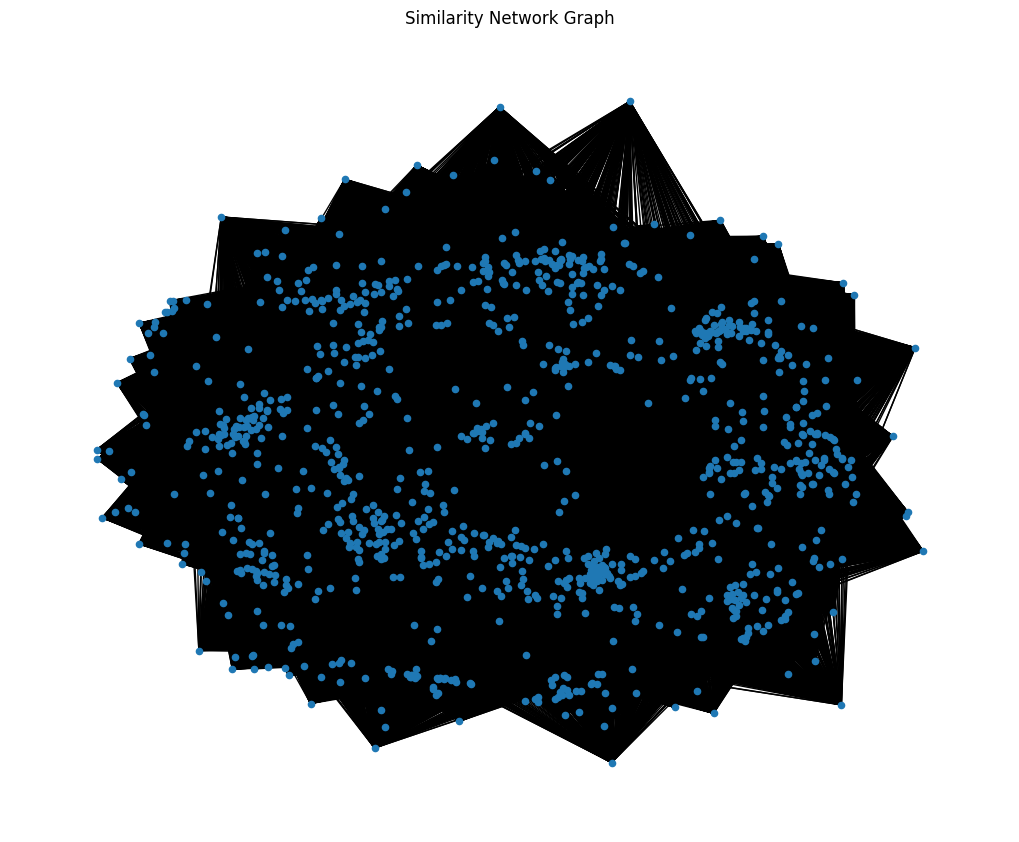

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Load your CSV data (replace 'your_data.csv' with your actual file path)
data = pd.read_csv('preds.csv', index_col=0)

# Create a graph
G = nx.Graph()

# Add nodes (images)
G.add_nodes_from(data.index)

# Add edges (similarity connections)
for img_id, similar_ids in data.iterrows():
    for sim_id in similar_ids:
        G.add_edge(img_id, sim_id)

# Draw the graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)  # Layout the nodes
nx.draw(G, pos, node_size=20, with_labels=False)
plt.title('Similarity Network Graph')
plt.show()


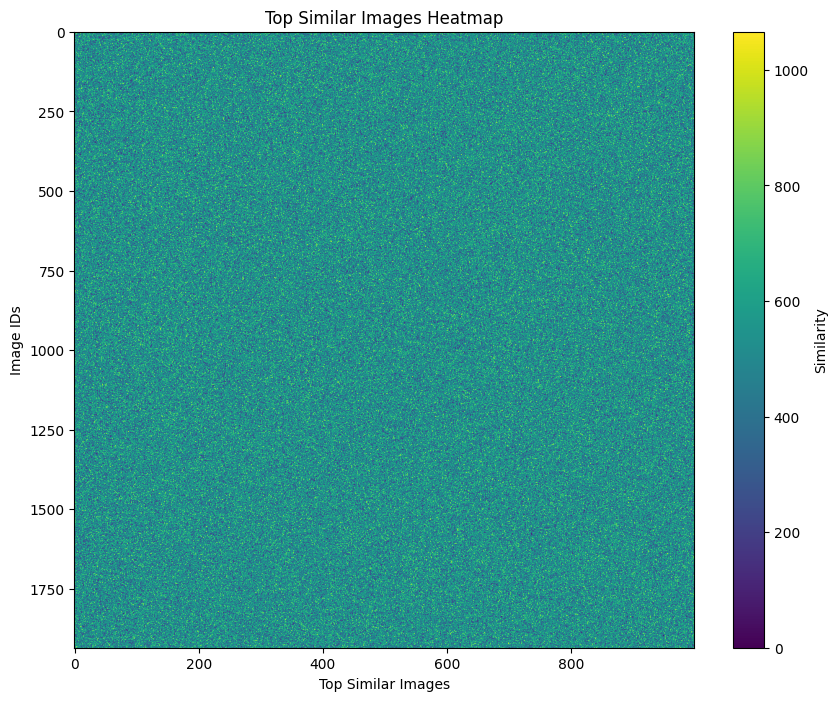

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load the prediction CSV file (replace 'predictions.csv' with your file path)
predictions = pd.read_csv('preds.csv', header=None)

# Convert the predictions DataFrame to a numpy array
predictions_array = predictions.to_numpy()

# Create a heatmap
plt.figure(figsize=(10, 8))
plt.imshow(predictions_array, cmap='viridis', aspect='auto')
plt.colorbar(label='Similarity')
plt.xlabel('Top Similar Images')
plt.ylabel('Image IDs')
plt.title('Top Similar Images Heatmap')
plt.show()


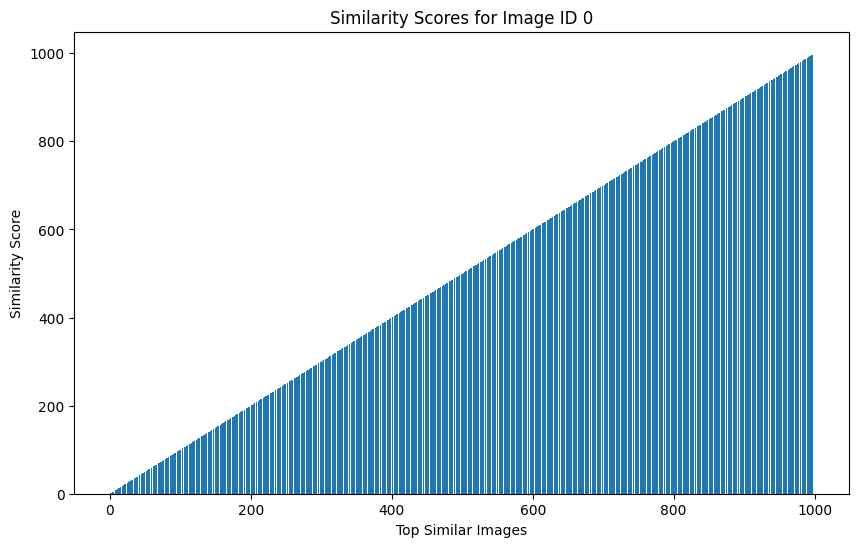

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the prediction CSV file (replace 'predictions.csv' with your file path)
predictions = pd.read_csv('preds.csv', header=None)

# Select an image ID (replace with the desired image ID)
image_id = 0

# Get the similarity scores for the selected image ID
similarity_scores = predictions.iloc[image_id]

# Plot the similarity scores as a bar plot
plt.figure(figsize=(10, 6))
plt.bar(range(len(similarity_scores)), similarity_scores)
plt.xlabel('Top Similar Images')
plt.ylabel('Similarity Score')
plt.title(f'Similarity Scores for Image ID {image_id}')
plt.show()


In [ ]:
output.shape

(1935, 1000)

In [ ]:
import pandas as pd

# Load the CSV file with image IDs


# Get the top 1000 image IDs and their respective image IDs
# num_images_to_display = 1000
# for i in range(num_images_to_display):
#     image_id = i
image_ids_list = output.iloc[0].tolist()

print(f"Image ID: 0 -> {image_ids_list}")


Image ID: 0 -> [768, 923, 972, 193, 511, 285, 771, 412, 266, 327, 825, 372, 466, 608, 507, 943, 441, 782, 558, 252, 56, 133, 751, 675, 254, 897, 871, 694, 624, 830, 0, 319, 685, 21, 136, 932, 969, 194, 1, 940, 388, 1052, 576, 265, 1066, 395, 67, 191, 221, 614, 848, 1063, 506, 317, 651, 556, 942, 708, 93, 959, 1015, 852, 107, 666, 228, 258, 241, 246, 635, 248, 445, 930, 705, 596, 209, 315, 357, 591, 747, 374, 202, 704, 460, 433, 639, 456, 379, 713, 640, 17, 314, 1035, 531, 29, 1013, 544, 585, 394, 993, 10, 497, 938, 197, 323, 519, 814, 114, 308, 335, 46, 442, 880, 681, 142, 956, 117, 199, 581, 210, 51, 151, 696, 112, 730, 303, 148, 167, 1043, 809, 80, 879, 947, 192, 359, 1062, 16, 415, 1038, 283, 222, 818, 58, 844, 789, 1033, 499, 343, 724, 672, 183, 423, 429, 922, 764, 463, 701, 259, 549, 643, 578, 24, 698, 735, 453, 765, 1005, 860, 801, 334, 917, 833, 886, 577, 145, 1001, 586, 352, 920, 333, 160, 384, 30, 532, 792, 386, 307, 601, 436, 439, 1065, 955, 597, 522, 682, 504, 720, 1000, 738

In [ ]:
Image.open("/content/drive/MyDrive/gallery/ambitious-tough-teal-from-asgard")

FileNotFoundError: ignored

In [ ]:
column_name = "seller_img_id"
df = pd.DataFrame(image_ids_list, columns=[column_name])

In [ ]:
csv_filename = "output.csv"  # Change this to your desired filename
df.to_csv(csv_filename, index=False)

In [ ]:
from google.colab import files

files.download("output.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the CSV file with user image IDs and paths
csv_path = 'your_csv_file.csv'
df = pd.read_csv(csv_path)

# User-specified image IDs
user_image_ids = [0]  # Example

# Filter image paths based on user-specified image IDs
selected_paths = df[df['user_img_id'].isin(user_image_ids)]['img_path'].tolist()

# Display the top 1000 images
num_images_to_display = 1000
for i in range(min(num_images_to_display, len(selected_paths))):
    img_path = selected_paths[i]
    img = mpimg.imread(img_path)

    plt.imshow(img)
    plt.title(f"User Image ID: {user_image_ids[i]}")
    plt.axis('off')
    plt.show()
